In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [2]:
pd.options.display.max_columns=50

In [3]:
df=pd.read_csv('weatherAUS.csv',encoding='utf-8')

In [4]:
df=df[pd.isnull(df['RainTomorrow'])==False]

In [5]:
df=df.fillna(df.mean())

<ipython-input-5-6f8c6f28e805>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [6]:
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else '1.40-50' if 40<x<=50 else '2.>50')

In [7]:
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.60' if x>60 else '0.<=60')

In [8]:
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

In [9]:
print(df)

              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW 

In [10]:
def probs(data, child, parent1=None,parent2=None):
  if parent1==None:
    prob=pd.crosstab(data[child], 'Empty', margins=False,normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
  elif parent1!=None:
    if parent2==None:
      prob=pd.crosstab(data[parent1],data[child],margins=False,normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
      prob=pd.crosstab([data[parent1],data[parent2]],data[child],margins=False,normalize='index').sort_index().to_numpy().reshape(-1).tolist()
  else: 
    print("Error in Probability Frequency Calculations")
  return prob


In [11]:

H9am = BbnNode(Variable(0,'H9am',['<=60', '>60']),probs(df,child='Humidity9amCat'))
H3pm = BbnNode(Variable(1,'H3pm',['<=60', '>60']),probs(df,child='Humidity3pmCat',parent1='Humidity9amCat'))
W = BbnNode(Variable(2,'W',['<=40','40-50', '>50']),probs(df,child='WindGustSpeedCat'))
RT = BbnNode(Variable(3,'RT',['No', 'Yes']),probs(df,child='RainTomorrow',parent1='Humidity3pmCat',parent2='WindGustSpeedCat'))


In [12]:
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am,H3pm,EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm,RT,EdgeType.DIRECTED)) \
    .add_edge(Edge(W,RT,EdgeType.DIRECTED)) 

In [13]:
join_tree = InferenceController.apply(bbn)

In [14]:
pos ={0: (-1,2), 1: (-1,0.5), 2: (1,0.5),3: (0,-1)}

In [15]:
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,
}

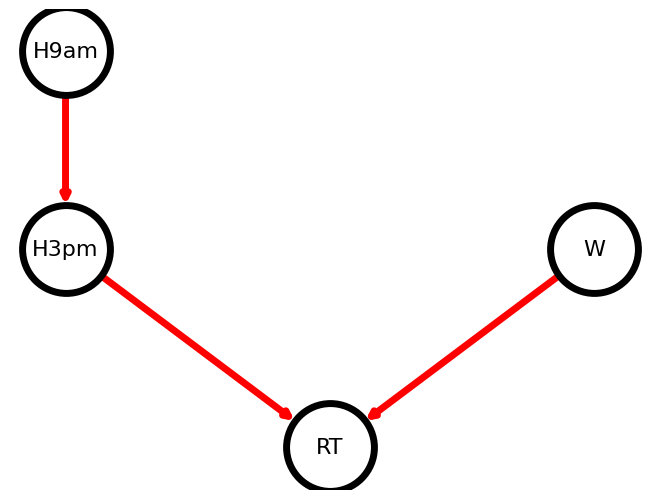

In [16]:
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

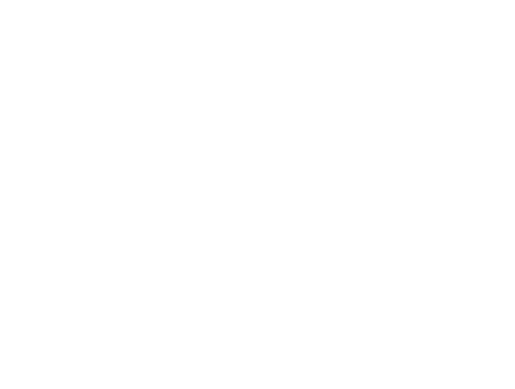

In [17]:
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()